<a href="https://colab.research.google.com/github/JJFelix/prediction-models/blob/master/cardio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

!pip install Boruta

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter
from imblearn.over_sampling import SMOTE
from boruta import BorutaPy

**1. Load Dataset**

In [6]:
# Load each disease data
cardio_data = pd.read_csv("cardio.csv")
data = cardio_data
data.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


**2. Data Preprocessing**

In [7]:
# drop education
data.drop(['education'], axis=1, inplace=True)
data.head()

# # # Label encoding categorical features (if any)
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# data["male"] = le.fit_transform(data["male"])

# # data.describe()
# data.describe(include =[np.number])
# # data.describe(include =[object])
data.head()

,male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


**3. Handling missing values**

In [8]:
# missing values
# data.fillna(data.mean(), inplace=True)
missing_data = data.isnull().sum()
total_percentage = (missing_data.sum() /data.shape[0]) * 100
print(f'Percentage of missing data: {round(total_percentage, 2)}%')

Percentage of missing data: 12.74%


In [9]:
# missing data per category
total = data.isnull().sum().sort_values(ascending=False)
percent_total = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)*100
missing = pd.concat([total, percent_total], axis=1, keys=["Total", "Percentage"])
missing_data = missing[missing['Total']>0]
missing_data

,Total,Percentage
glucose,388,9.150943
BPMeds,53,1.250000
totChol,50,1.179245
cigsPerDay,29,0.683962
BMI,19,0.448113
heartRate,1,0.023585


In [10]:
# drop null entries (they are only 12%)
data.dropna(axis=0, inplace=True)
# data.to_csv('c_data.csv', index=False)
# X = data.iloc[:,:-1]
# y = data.iloc[:,-1].values.reshape(-1,1)

# # Save features (X) to a CSV file
# X.to_csv('features.csv', index=False)

# # Save labels (y) to a CSV file
# pd.DataFrame(y).to_csv('labels.csv', index=False)

# X.shape
# y.shape

In [11]:
# data.info()

# positive_count = cardio_data[cardio_data["TenYearCHD"] == 1].shape[0]
# negative_count = cardio_data[cardio_data["TenYearCHD"] == 0].shape[0]

# Print the counts
# print(f"Positive instances: {positive_count}")
# print(f"Negative instances: {negative_count}")

# dataset imbalanced

**4. Viewing the data distribution**

<ipython-input-12-28956f241dd2>:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data.hist(ax = ax)


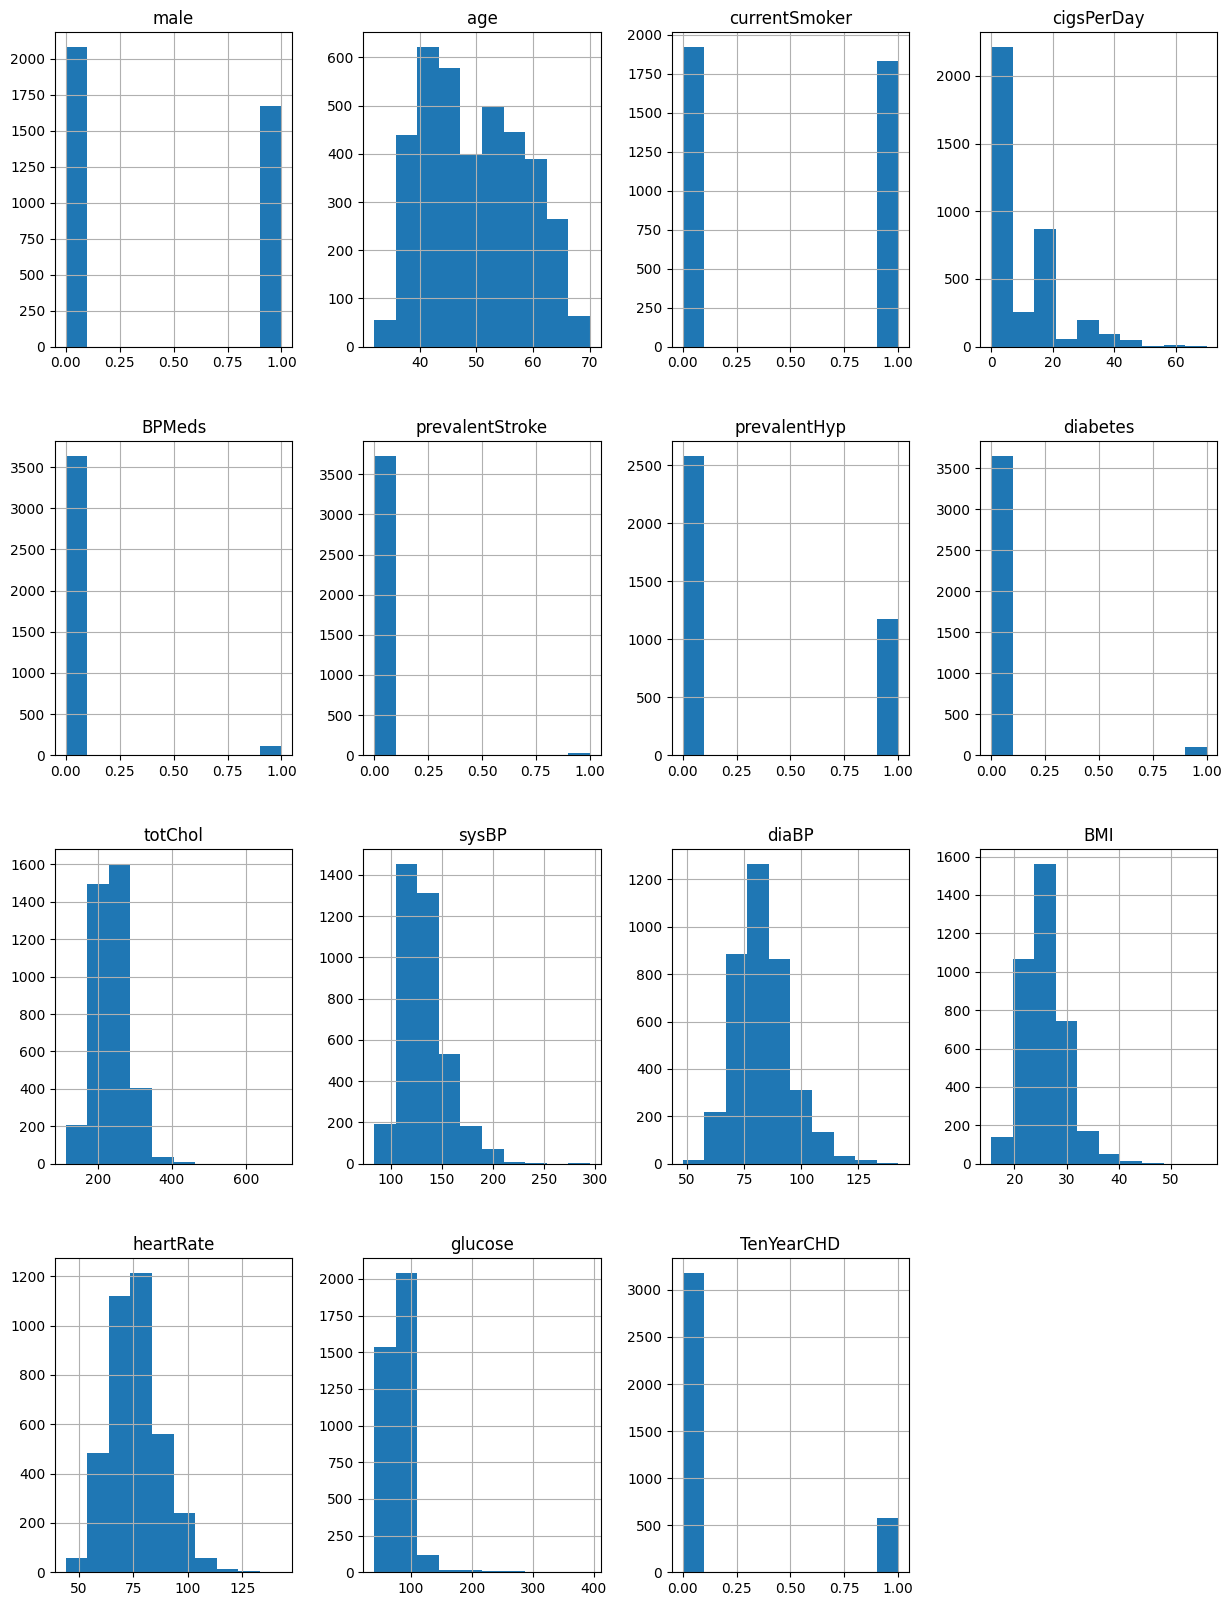

In [12]:
# plot histogram to see the distribution of the data
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
data.hist(ax = ax)
plt.show()

From the above distribution, some classes are imbalanced, i.e. Prevalent Stroke, Diabetes, and blood pressure meds.

**4.1. Case Counts**

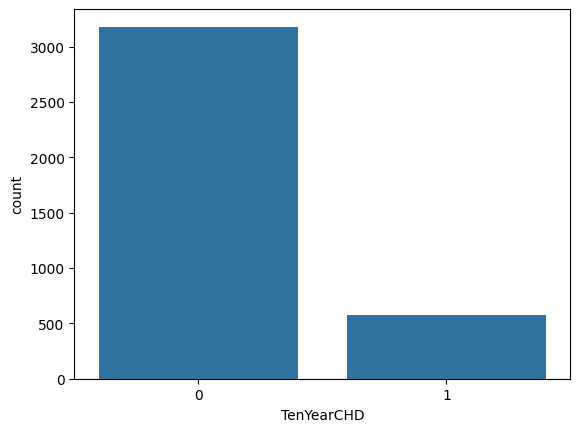

There are 3179 patients without heart disease and 572 patients with the disease


In [13]:
sns.countplot(x='TenYearCHD',data=data)
plt.show()
cases = data.TenYearCHD.value_counts()
print(f"There are {cases[0]} patients without heart disease and {cases[1]} patients with the disease")

**4.2. Disease vs Age**

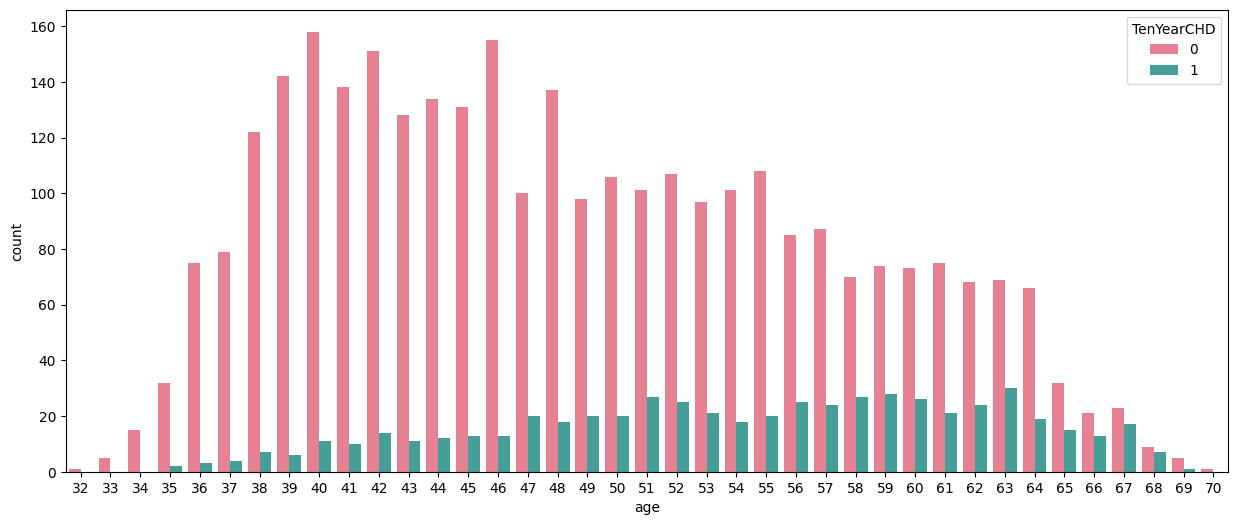

In [14]:
plt.figure(figsize=(15,6))
sns.countplot(x='age',data = data, hue = 'TenYearCHD',palette='husl')
plt.show()

The people with the highest risk of developing CHD are betwwen the ages of 51 and 63

**4.3. Correlation Heatmap**

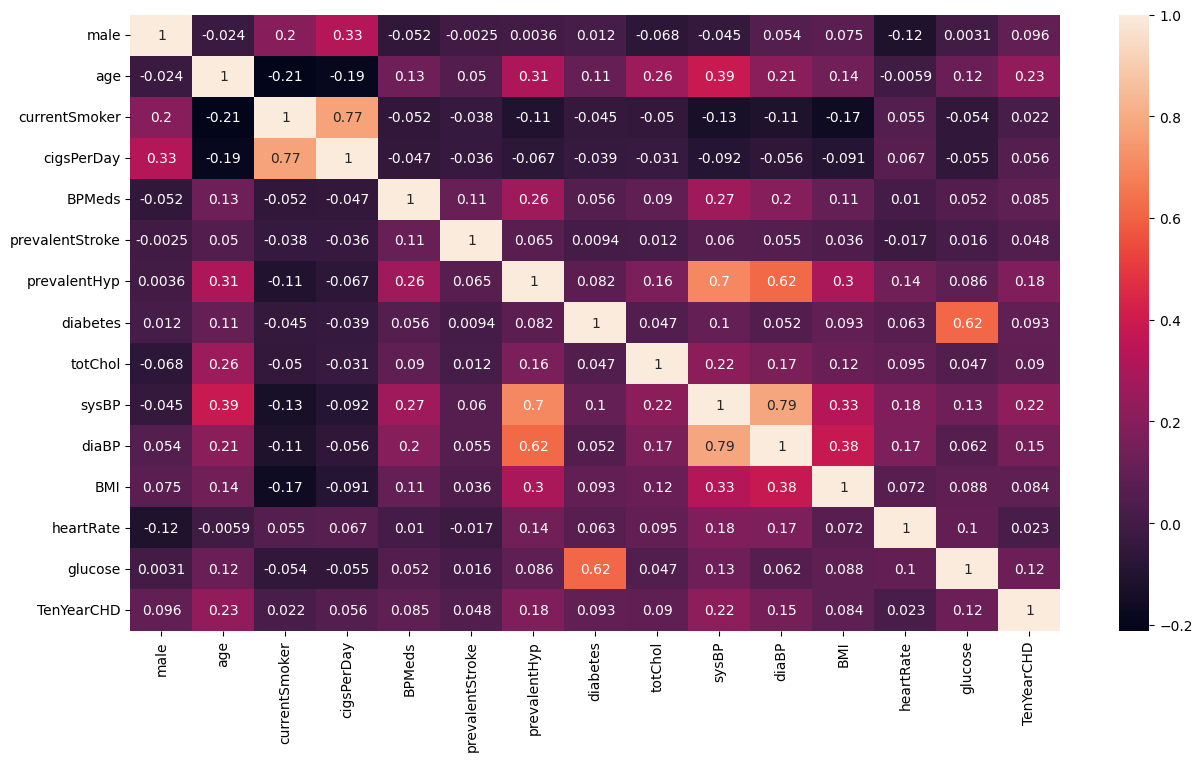

In [15]:
plt.figure(figsize=(15,8))
sns.heatmap(data.corr(), annot = True)
plt.show()

There are no features with more than 0.5 correlation with the Ten year risk of developing CHD and this shows that the features are poor predictors.

Also there are a couple of features that are highly correlated with one another and it makes no sense to use both of them in building a machine learning model. These incluse: *Blood glucose* and *diabetes*; *systolic* and *diastolic blood pressures*; *cigarette smoking* and the *number of cigarretes smoked per day*. Therefore we need to carry out feature selection to pick the best features.

**5. Feature Selection**

In [16]:
# define the features
X = data.iloc[:,:-1].values
y = data.iloc[:,-1].values
np.int = np.int32
np.float = np.float64
np.bool = np.bool_

forest = RandomForestClassifier(n_estimators=1000, n_jobs=-1, class_weight='balanced')

# define Boruta feature selection method
feat_selector = BorutaPy(forest, n_estimators='auto', verbose=2, random_state=1)

# find all relevant features
feat_selector.fit(X, y)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	2
Tentative: 	4
Rejected: 	8
Iteration: 	9 / 100
Confirmed: 	2
Tentative: 	4
Rejected: 	8
Iteration: 	10 / 100
Confirmed: 	2
Tentative: 	4
Rejected: 	8
Iteration: 	11 / 100
Confirmed: 	2
Tentative: 	4
Rejected: 	8
Iteration: 	12 / 100
Confirmed: 	2
Tentative: 	4
Rejected: 	8
Iteration: 	13 / 100
Confirmed: 	2
Tentative: 	4
Rejected: 	8
Iteration: 	14 / 100
Confirmed: 	2
Tentative: 	4
Rejected: 	8
Iteration: 	15 / 100
Confirmed: 	2
Tentative: 	4
Rejected: 	8
Iteration: 	16 / 100
Confirmed: 	2
Tentative: 	4
Rejected: 	8
Iteration:

BorutaPy(estimator=RandomForestClassifier(class_weight='balanced',
                                          n_estimators=28, n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x7B280B4A1E40),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7B280B4A1E40, verbose=2)

In [17]:
# most important features
most_important = data.columns[:-1][feat_selector.support_].tolist()
most_important

['age', 'sysBP']

In [18]:
# select the top 9 features
top_features = data.columns[:-1][feat_selector.ranking_ <=8].tolist()
top_features

['age',
 'cigsPerDay',
 'prevalentHyp',
 'totChol',
 'sysBP',
 'diaBP',
 'BMI',
 'heartRate',
 'glucose']

In [19]:
import statsmodels.api as sm

X_top = data[top_features]
y = data['TenYearCHD']

res = sm.Logit(y,X_top).fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.404117
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             TenYearCHD   No. Observations:                 3751
Model:                          Logit   Df Residuals:                     3742
Method:                           MLE   Df Model:                            8
Date:                Tue, 26 Mar 2024   Pseudo R-squ.:                 0.05361
Time:                        09:32:55   Log-Likelihood:                -1515.8
converged:                       True   LL-Null:                       -1601.7
Covariance Type:            nonrobust   LLR p-value:                 5.582e-33
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
age              0.0307      0.006      5.379      0.000       0.020       0.042
cigsPerDay       0.0195      0.004      5.152      0.000       0.012       0.027
prevalentHyp     1.0536      0.119      8.848      0.000       0.820       1.287
totChol         -0.0020      0.001     -1.863      0.062      -0.004       0.000
sysBP            0.0115      0.004      3.139      0.002       0.004       0.019
diaBP           -0.0280      0.006     -4.796      0.000      -0.039      -0.017
BMI             -0.0400      0.012     -3.346      0.001      -0.063      -0.017
heartRate       -0.0266      0.004     -6.884      0.000      -0.034      -0.019
glucose          0.0055      0.002      3.400      0.001       0.002       0.009
================================================================================
"""

In [20]:
params = res.params
conf = res.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['5%', '95%', 'Odds Ratio']
print(np.exp(conf))

                    5%       95%  Odds Ratio
age           1.019734  1.042836    1.031220
cigsPerDay    1.012145  1.027262    1.019676
prevalentHyp  2.270986  3.621803    2.867937
totChol       0.995908  1.000104    0.998004
sysBP         1.004342  1.018918    1.011604
diaBP         0.961291  0.983564    0.972364
BMI           0.938562  0.983573    0.960804
heartRate     0.966459  0.981185    0.973794
glucose       1.002339  1.008736    1.005532


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-pack

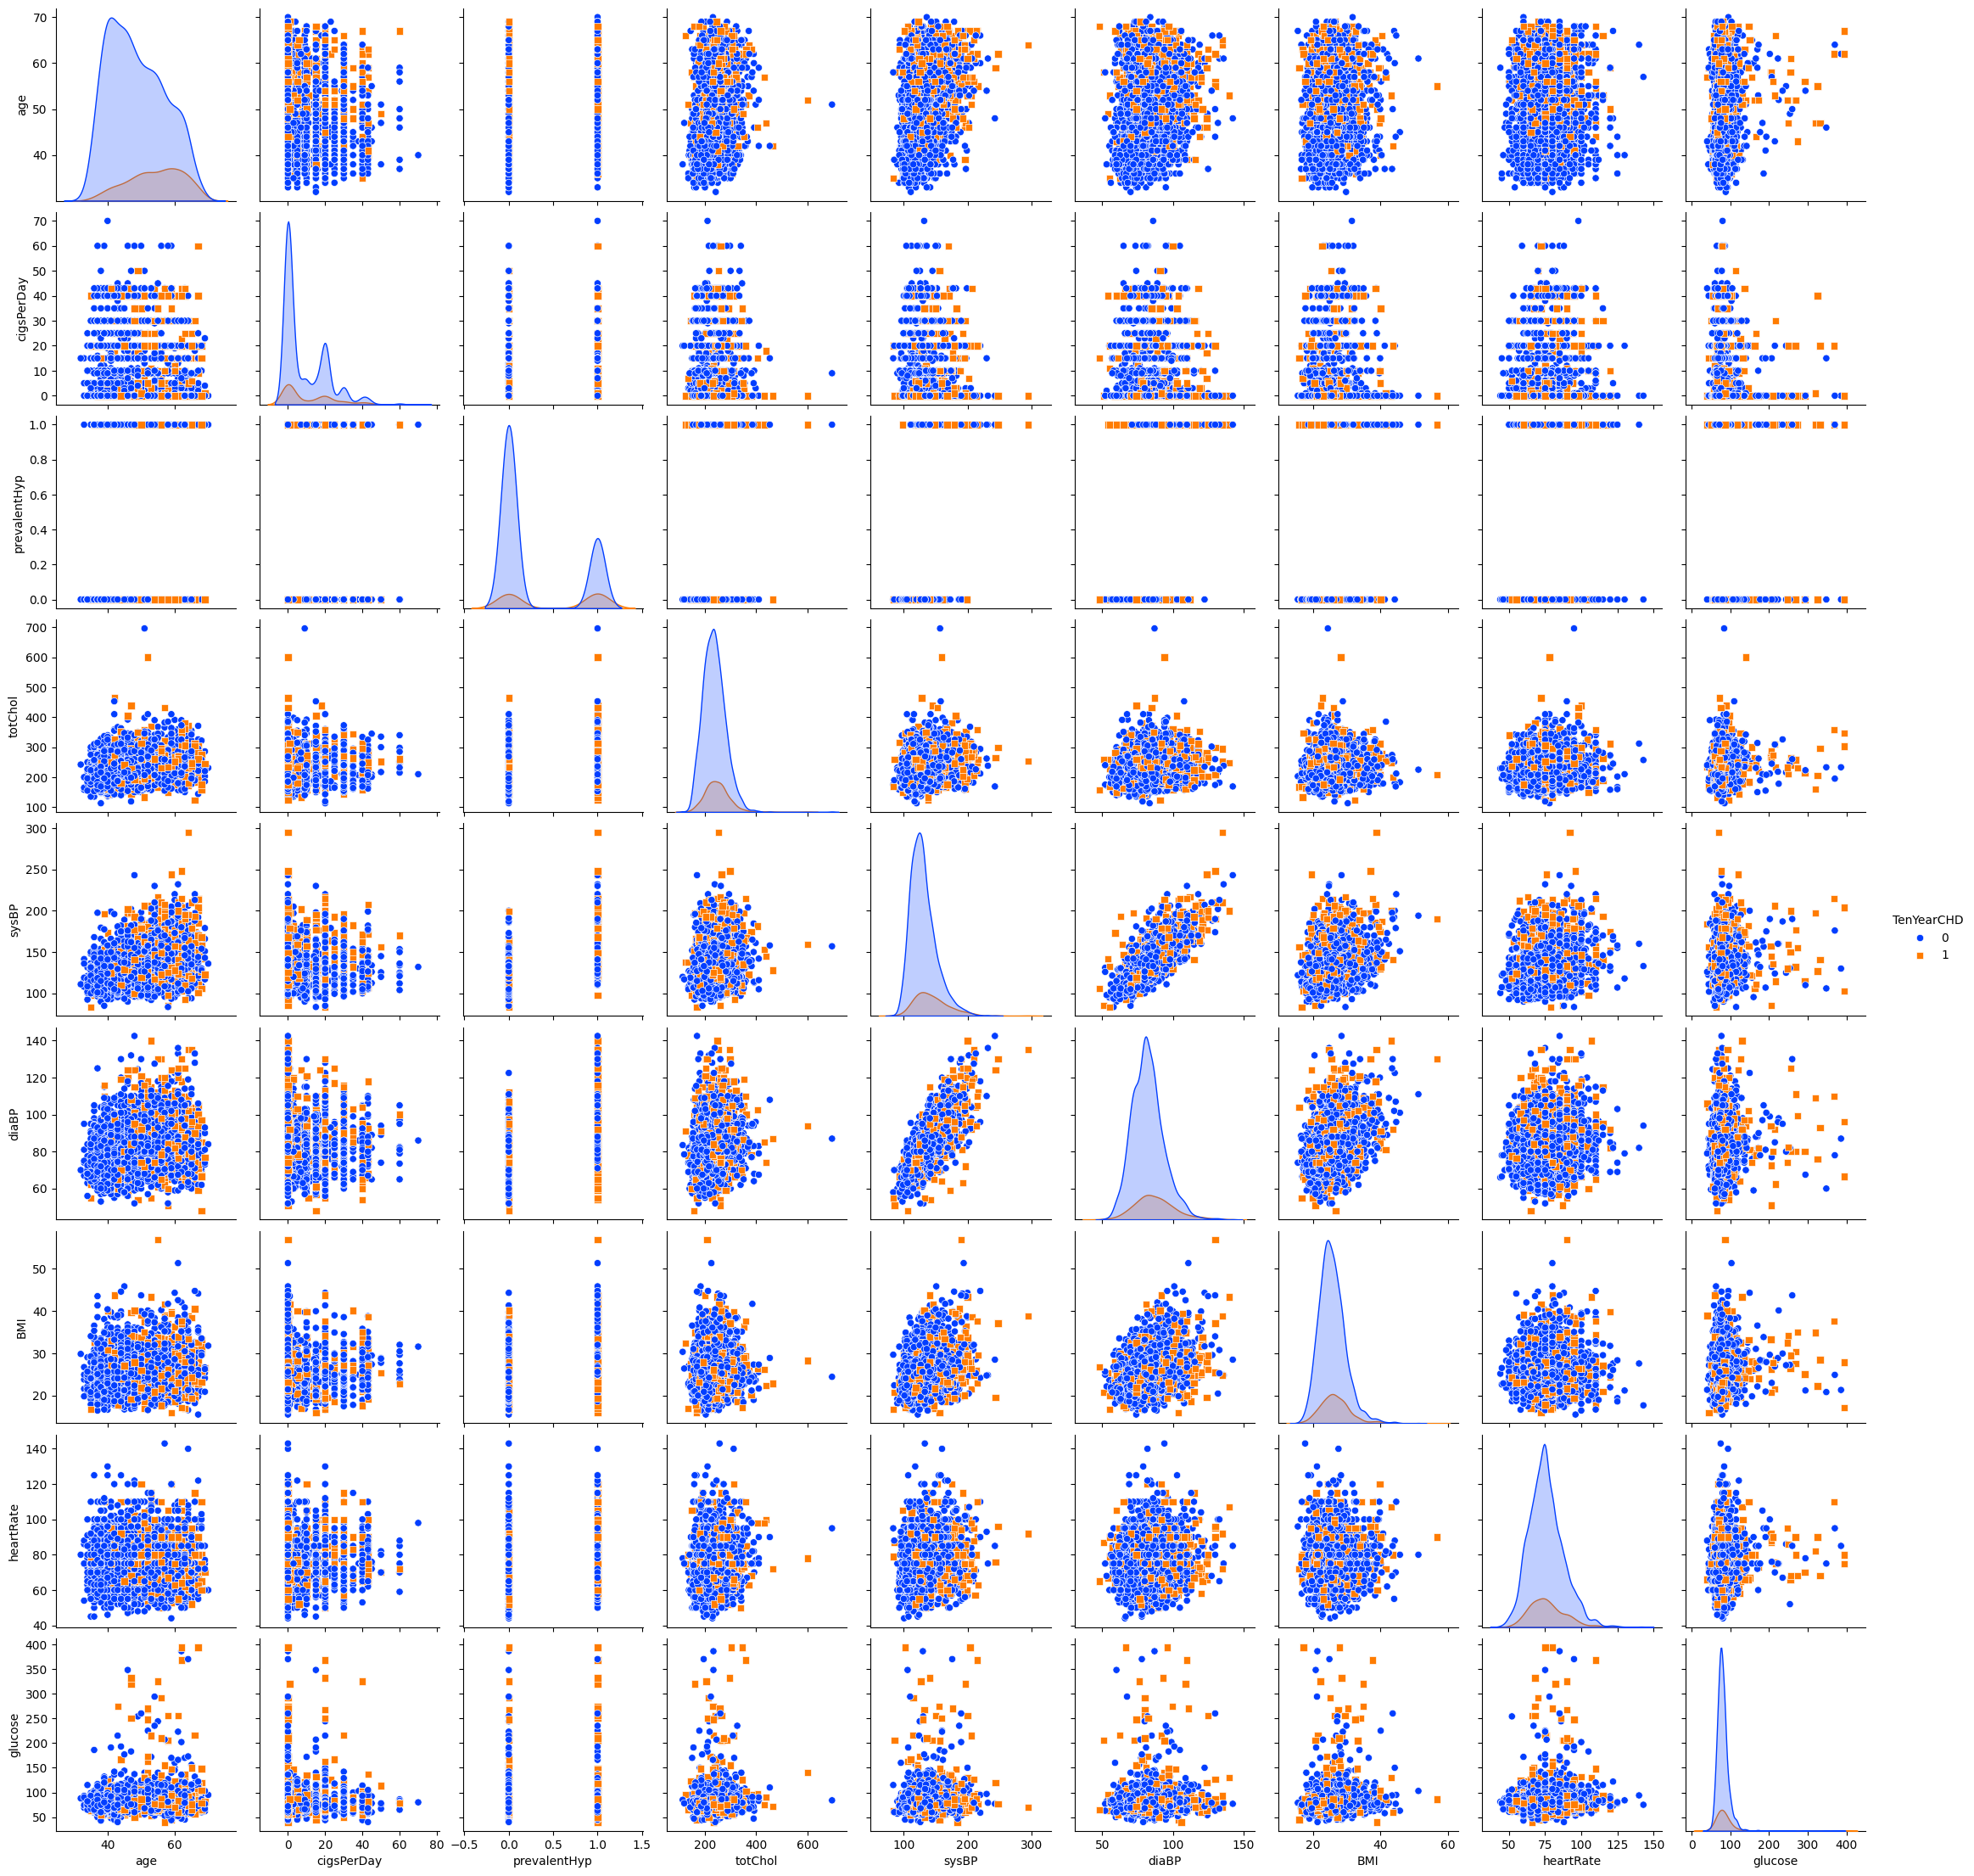

In [21]:
# sns.pairplot(data, hue = 'TenYearCHD', markers=["o", "s"], vars = top_features, palette = sns.color_palette("bright", 10))

**6. Balancing dataset - SMOTE**

In [22]:
# rectifying class imbalance
# 1. Oversampling
# from imblearn.over_sampling import RandomOverSampler
# X = data.drop("TenYearCHD", axis=1) # features
# y = data["TenYearCHD"] # target

# ros = RandomOverSampler(random_state=42)
# X_resampled, y_resampled = ros.fit_resample(X, y)

In [23]:
# 2. Undersamping - not ideal (throws away data)
# from sklearn.utils import resample
# X = cardio_data.drop("TenYearCHD", axis=1).iloc[:, :] # features
# y = cardio_data["TenYearCHD"] # target

# X_resampled, y_resampled = resample(X[y == 0],
#                                       replace=False,
#                                       n_samples=len(y[y == 1]),
#                                       random_state=42)

# X_resampled2 = pd.concat([X_resampled, X[y == 1]], ignore_index=True)
# y_resampled2 = pd.concat([y[y_resampled], y[y == 1]], ignore_index=True)


In [24]:
X = data[top_features]
y  = data.iloc[:,-1]

In [25]:
# the numbers before smote
num_before = dict(Counter(y))

# smoting
# define pipeline
over = SMOTE(sampling_strategy=0.8)
under = RandomUnderSampler(sampling_strategy=0.8)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# transform the dataset
X_smote, y_smote = pipeline.fit_resample(X, y)

#the numbers after smote
num_after =dict(Counter(y_smote))

print(num_before, num_after)

{0: 3179, 1: 572} {0: 3178, 1: 2543}


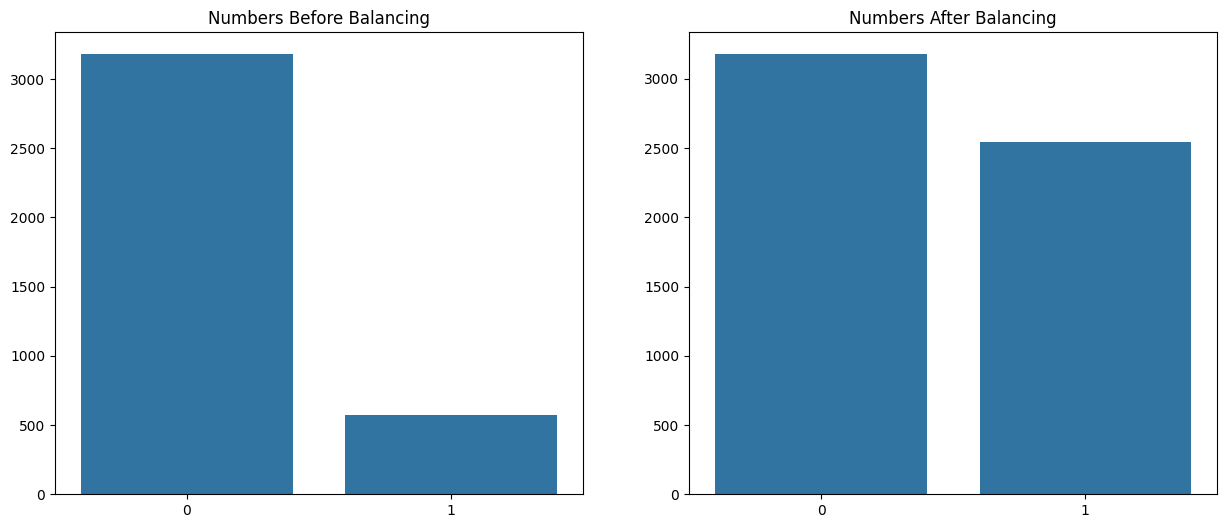

In [26]:
labels = ["Negative Cases","Positive Cases"]
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.barplot(list(num_before.values()))
plt.title("Numbers Before Balancing")
plt.subplot(1,2,2)
sns.barplot(list(num_after.values()))
plt.title("Numbers After Balancing")
plt.show()

In [27]:
# 3. SMOTE - Synthetic Minority Over-sampling Technique
# '''
# Creates synthetic data pounts for the minority class based on existing data
# '''
# from imblearn.over_sampling import SMOTE
# X = cardio_data.drop("TenYearCHD", axis=1) # features
# y = cardio_data["TenYearCHD"] # target

# smote = SMOTE(random_state=42)
# X_resampled3, y_resampled3 = smote.fit_resample(X, y)
print(top_features)


['age', 'cigsPerDay', 'prevalentHyp', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']


**7. Training and Testing Set**

In [28]:
# new dataset
new_data = pd.concat([pd.DataFrame(X_smote), pd.DataFrame(y_smote)], axis=1)
new_data.columns =  ['age', 'cigsPerDay', 'prevalentHyp', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose', 'TenYearCHD']
new_data.head()

,age,cigsPerDay,prevalentHyp,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,56,0.0,0,212.0,130.0,79.0,27.73,64.0,100.0,0
1,59,1.0,0,232.0,108.0,73.0,24.92,65.0,81.0,0
2,50,20.0,1,213.0,140.0,82.0,22.18,64.0,72.0,0
3,60,5.0,1,246.0,160.0,92.0,26.38,80.0,73.0,0
4,48,5.0,0,192.0,135.0,82.5,32.67,67.0,69.0,0


In [29]:
X_new = new_data[top_features]
y_new = new_data.iloc[:,-1]
X_new.head()
y_new.head()

0    0
1    0
2    0
3    0
4    0
Name: TenYearCHD, dtype: int64

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=.2, random_state=42)

**8. Feature Scaling**

In [31]:
scaler  = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled)

X_test_scaled = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_scaled)

X_test.head()

,0,1,2,3,4,5,6,7,8
0,0.359665,-0.530861,-0.719195,-1.489137,-0.645231,-0.432996,0.042784,-0.075161,-0.520976
1,0.480336,-0.784244,-0.719195,0.395321,-0.559962,0.376771,1.347551,0.790204,-0.019489
2,1.204360,-0.738727,-0.719195,0.553962,0.545209,0.885908,-0.424198,-0.264817,-0.234011
3,0.601006,-0.555858,-0.719195,0.110729,0.180917,0.332978,-0.173366,-1.174523,-0.789626
4,0.359665,-0.784244,-0.719195,1.016084,-1.114207,-0.837879,0.060553,-0.940525,0.168569


**9. Models**

**9.1 Bagged Decision Trees**

In [32]:
bagged_dt = BaggingClassifier(estimator=DecisionTreeClassifier())

# grid search for optimum parameters
params = {
    'n_estimators': [10, 50, 100, 200],
    'base_estimator__max_depth': [None] + list(np.arange(10, 31, 5)),
    'base_estimator__min_samples_split': list(np.arange(2, 16)),
    'base_estimator__min_samples_leaf': list(np.arange(1, 12)),
    'max_features': [0.5, 0.75, 1.0],  # Fraction of features to consider for each base estimator
    'bootstrap': [True, False],  # Whether samples are drawn with replacement
    'bootstrap_features': [True, False]  # Whether features are drawn with replacement
}

n_iter_search = 100
bagged_dt_clf = RandomizedSearchCV(estimator=bagged_dt, param_distributions=params, n_iter=n_iter_search, cv=5, n_jobs=-1)

In [33]:
# training
bagged_dt_clf.fit(X_train, y_train)
bagged_dt_clf.best_params_

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:905: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  clone(base_estimator).set_params(**self.best_params_)


{'n_estimators': 100,
 'max_features': 0.5,
 'bootstrap_features': True,
 'bootstrap': False,
 'base_estimator__min_samples_split': 11,
 'base_estimator__min_samples_leaf': 4,
 'base_estimator__max_depth': None}

In [34]:
# predictions
bagged_dt_predict = bagged_dt_clf.predict(X_test)

# accuracy and f1
bagged_dt_accuracy = accuracy_score(y_test, bagged_dt_predict)
bagged_dt_f1 = f1_score(y_test, bagged_dt_predict)

print(f"Bagged Decision Trees accuracy: {round(bagged_dt_accuracy*100,2)}%")
print(f'The f1 score for BDT is {round(bagged_dt_f1*100,2)}%')

Bagged Decision Trees accuracy: 89.08%
The f1 score for BDT is 86.54%


<Axes: >

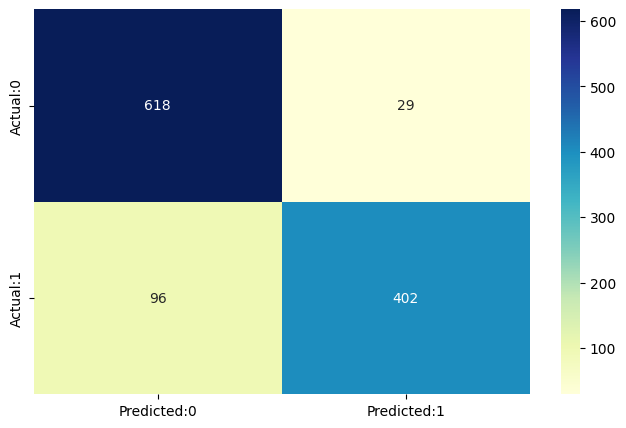

In [35]:
# confusion matrix
cm=confusion_matrix(y_test, bagged_dt_predict)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

In [36]:
# classification report
print(classification_report(y_test,bagged_dt_predict))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91       647
           1       0.93      0.81      0.87       498

    accuracy                           0.89      1145
   macro avg       0.90      0.88      0.89      1145
weighted avg       0.89      0.89      0.89      1145



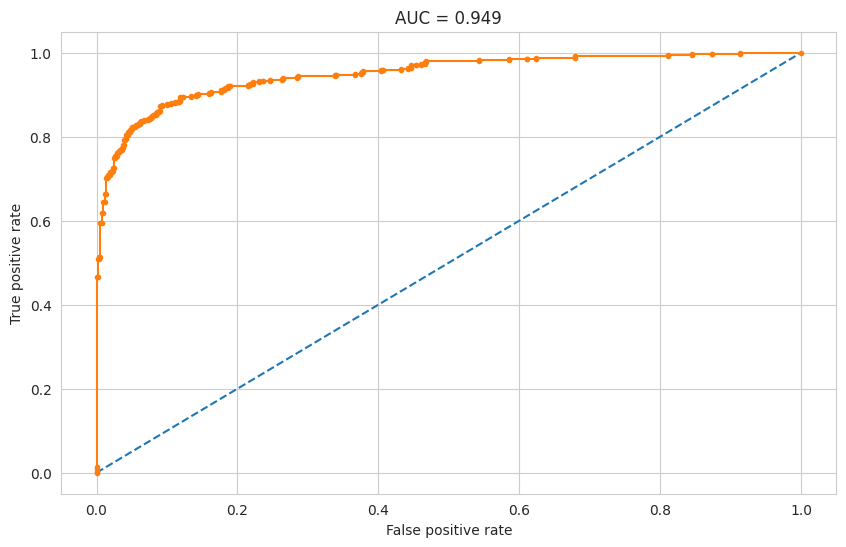

In [37]:
# ROC and AUC
# ROC curve and AUC
probs = bagged_dt_clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
bagged_dt_auc = roc_auc_score(y_test, probs)

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot curve
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title(f"AUC = {round(bagged_dt_auc,3)}")
plt.show()

**9.2 Random Forest**

In [38]:
rf = RandomForestClassifier(n_estimators=100)

# grid search for optimum parameters
params = {
    'n_estimators': [10, 50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],  # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2']  # Number of features to consider when looking for the best split
}
n_iter_search = 100
rf_clf = RandomizedSearchCV(estimator=rf, param_distributions=params, n_iter=n_iter_search, cv=5, n_jobs=-1)

In [39]:
rf_clf.fit(X_train, y_train)
rf_clf.best_params_

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


{'n_estimators': 100,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 20}

In [40]:
# predictions
rf_predict = rf_clf.predict(X_test)

# accuracy and f1
rf_accuracy = accuracy_score(y_test, rf_predict)
rf_f1 = f1_score(y_test, rf_predict)

print(f"RandomForest accuracy: {round(rf_accuracy*100,2)}%")
print(f'The f1 score for RF is {round(rf_f1*100,2)}%')

RandomForest accuracy: 85.85%
The f1 score for RF is 83.67%


<Axes: >

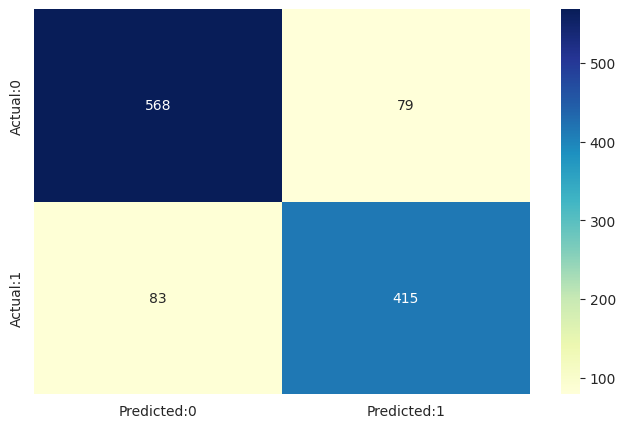

In [41]:
# confusion matrix
cm=confusion_matrix(y_test, rf_predict)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

In [42]:
# classification report
print(classification_report(y_test,rf_predict))

              precision    recall  f1-score   support

           0       0.87      0.88      0.88       647
           1       0.84      0.83      0.84       498

    accuracy                           0.86      1145
   macro avg       0.86      0.86      0.86      1145
weighted avg       0.86      0.86      0.86      1145



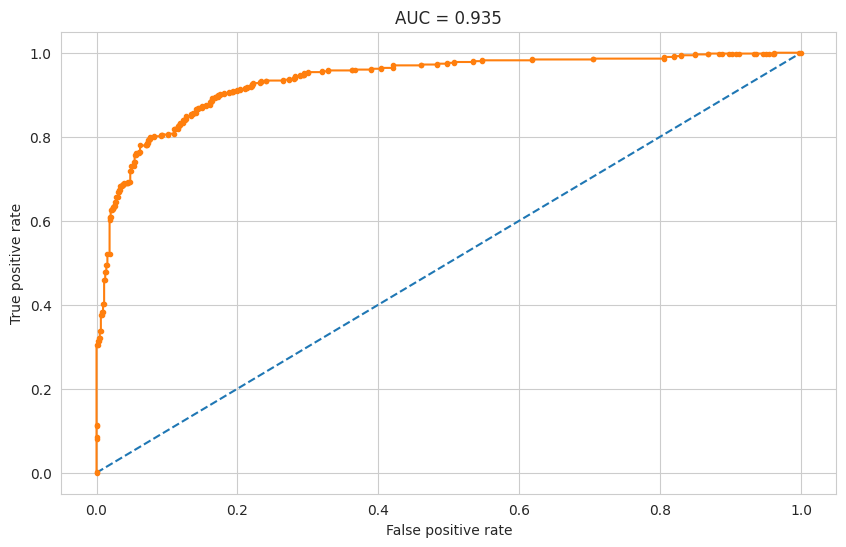

In [43]:
# ROC and AUC
# ROC curve and AUC
probs = rf_clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
rf_auc = roc_auc_score(y_test, probs)

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot curve
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title(f"AUC = {round(rf_auc,3)}")
plt.show()

**9.3 Stochastic Gradient Boosting**

In [44]:
gb = GradientBoostingClassifier()

# Define the parameter grid
params = {
    'n_estimators': [10, 50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'min_samples_split': list(np.arange(2, 16)),
    'min_samples_leaf': list(np.arange(1, 12)),
    'max_features': [0.5, 0.75, 1.0],
    'subsample': [0.5, 0.75, 1.0]
}

n_iter_search = 100

gb_clf = RandomizedSearchCV(estimator=gb, param_distributions=params, n_iter=n_iter_search, cv=5, n_jobs=-1)

In [45]:
# Train the model
gb_clf.fit(X_train, y_train)
gb_clf.best_params_

{'subsample': 0.75,
 'n_estimators': 200,
 'min_samples_split': 6,
 'min_samples_leaf': 10,
 'max_features': 1.0,
 'max_depth': 5,
 'learning_rate': 0.2}

In [46]:
# predictions
gb_predict = gb_clf.predict(X_test)

# accuracy and f1
gb_accuracy = accuracy_score(y_test, gb_predict)
gb_f1 = f1_score(y_test, gb_predict)

print(f"SGB accuracy: {round(gb_accuracy*100,2)}%")
print(f'The f1 score for gb is {round(gb_f1*100,2)}%')

SGB accuracy: 88.65%
The f1 score for gb is 86.63%


<Axes: >

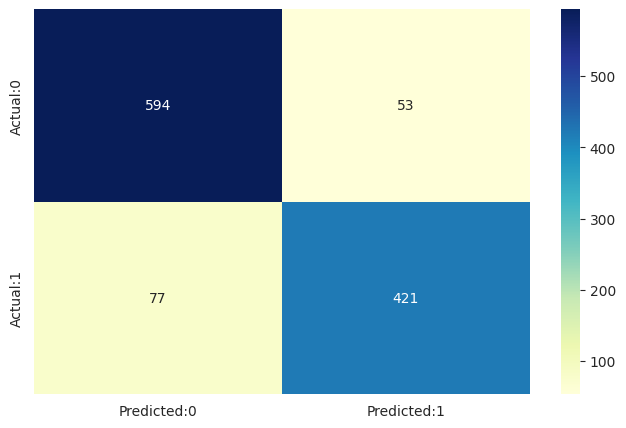

In [47]:
# confusion matrix
cm=confusion_matrix(y_test, gb_predict)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

In [48]:
# classification report
print(classification_report(y_test,gb_predict))

              precision    recall  f1-score   support

           0       0.89      0.92      0.90       647
           1       0.89      0.85      0.87       498

    accuracy                           0.89      1145
   macro avg       0.89      0.88      0.88      1145
weighted avg       0.89      0.89      0.89      1145



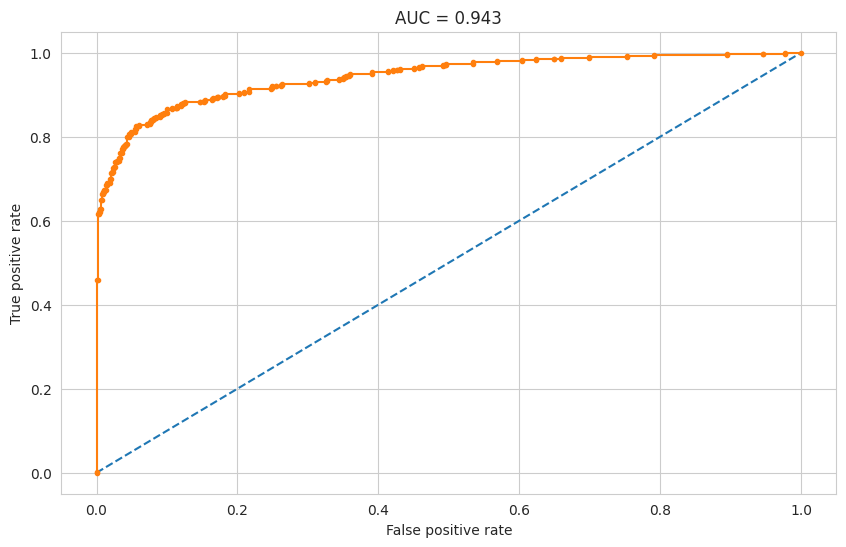

In [49]:
# ROC and AUC
# ROC curve and AUC
probs = gb_clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
gb_auc = roc_auc_score(y_test, probs)

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot curve
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title(f"AUC = {round(gb_auc,3)}")
plt.show()

**10. Building the ensemble**

In [50]:
ensemble = VotingClassifier(
    estimators=[
        ('bagged_tree', bagged_dt_clf),
        ('random_forest', rf_clf),
        ('gradient_boosting', gb_clf)
    ], voting='soft')

ensemble.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:905: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  clone(base_estimator).set_params(**self.best_params_)


VotingClassifier(estimators=[('bagged_tree',
                              RandomizedSearchCV(cv=5,
                                                 estimator=BaggingClassifier(estimator=DecisionTreeClassifier()),
                                                 n_iter=100, n_jobs=-1,
                                                 param_distributions={'base_estimator__max_depth': [None,
                                                                                                    10,
                                                                                                    15,
                                                                                                    20,
                                                                                                    25,
                                                                                                    30],
                                                                      'base_estimator__min_samples_leaf': [1,
                                                                                                           2,
                                                                                                           3,
                                                                                                           4,
                                                                                                           5,
                                                                                                           6,
                                                                                                           7,
                                                                                                           8,
                                                                                                           9,
                                                                                                           10,
                                                                                                           11],
                                                                      'base_estimator__min_samples_split': [2,
                                                                                                            3,
                                                                                                            4,
                                                                                                            5,
                                                                                                            6,
                                                                                                            7,
                                                                                                            8,
                                                                                                            9,
                                                                                                            10,
                                                                                                            11,
                                                                                                            12,
                                                                                                            13,...
                              RandomizedSearchCV(cv=5,
                                                 estimator=GradientBoostingClassifier(),
                                                 n_iter=100, n_jobs=-1,
                                                 param_distributions={'learning_rate': [0.01,
                                                                                        0.05,
                                                                                        0.1,
                                      

In [51]:
# predictions
ensemble_predict = ensemble.predict(X_test)

# accuracy and f1
ensemble_accuracy = accuracy_score(y_test, ensemble_predict)
ensemble_f1 = f1_score(y_test, ensemble_predict)

print(f"ensemble accuracy: {round(ensemble_accuracy*100,2)}%")
print(f'The f1 score for ensemble is {round(ensemble_f1*100,2)}%')

ensemble accuracy: 89.87%
The f1 score for ensemble is 88.16%


In [52]:
# predict probabilities
proba_scores = ensemble.predict_proba(X_test)
print(proba_scores)

[[0.7649217  0.2350783 ]
 [0.80098539 0.19901461]
 [0.10941547 0.89058453]
 ...
 [0.45832482 0.54167518]
 [0.78304311 0.21695689]
 [0.25778895 0.74221105]]


```
[63,0,0,205,138,71,33.11,60,85]
[46,23,0,285,130,84,23.1,85,85]
[61,30,1,225,150,95,28.58,65,103]
[48, 10, 1, 232, 138, 90, 22.37, 64, 72]
[50,0,0,254,133,76,22.91,75,76]
```

In [61]:
patient_data = [[50,0,0,254,133,76,22.91,75,76]]
scaled_patient_data = scaler.transform(patient_data)
scaled_patient_data_2d = np.array(scaled_patient_data).reshape(1,-1)
scaled_patient_data_2d
proba_scores = ensemble.predict_proba(scaled_patient_data_2d)

print("Probability score for class 1(risk score): ", proba_scores[0][1])

Probability score for class 1(risk score):  0.06887422612805023


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


**11. Saving the model**

In [54]:
import pickle, joblib
file_path = 'cardio_ensemble_model.pkl'

# with open(file_path, 'wb') as file:
#   pickle.dump(ensemble, file)

# using joblib
joblib.dump(ensemble, "cardio_ensemble_model.joblib", compress=3)

print('Ensemble model saved successfully')

Ensemble model saved successfully
